In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

/tmp/ipykernel_26201/2796411842.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
df = pd.read_pickle("all_df.pkl")
test_df_original = pd.read_pickle("all_df_test.pkl")

In [ ]:
def plot_nan_freq(df):
    nan_counts = df.isnull().sum().sort_values(ascending=False)
    nan_perc = nan_counts / len(df) * 100
    print(nan_perc)
    # Define color palette
    colors = sns.color_palette("rocket", len(nan_counts))
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(nan_counts.index, nan_perc.values, color=colors)
    ax.set_xticks(range(len(nan_counts)))
    ax.set_xticklabels(nan_counts.index, rotation=90, ha='center', fontsize=10)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.set_ylabel('Percentage of NaN values', fontweight = "bold")
    ax.set_xlabel('Data columns', fontweight = "bold")
    ax.set_title('Missing data Frequency per Column', fontweight = "bold")
    y_ticks = np.arange(0, 101, 10)
    ax.set_yticks(y_ticks)
    plt.grid(False)

    # Add text labels to highest and lowest non-zero bars
    non_zero_perc = nan_perc[nan_perc > 0]
    if len(non_zero_perc) > 0:
        max_idx = non_zero_perc.idxmax()
        min_idx = non_zero_perc.idxmin()
        ax.text(max_idx, non_zero_perc[max_idx]+1, f'{non_zero_perc[max_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')
        ax.text(min_idx, non_zero_perc[min_idx]+3, f'{non_zero_perc[min_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')

    plt.show()

In [ ]:
plot_nan_freq(df)

In [ ]:
columns = df.columns.tolist()

fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Distributions of the columns", fontsize=15, fontweight="bold", y=0.9)

i = 0
for col in df.columns:
    if col != "patient id":
        if df[col].nunique() == 2:
            if col != 'SepsisLabel':
                counts = df.groupby('patient id')[col].mean().value_counts()
            else:
                counts = df[col].value_counts()
            if counts[1]/(counts[0]+counts[1]) > 0.95 or counts[1]/(counts[0]+counts[1]) < 0.05:
                axes[i//5, i%5].pie(counts, labels=counts.index, autopct='%1.1f%%', explode=(0, 0.8))
            else:
                axes[i//5, i%5].pie(counts, labels=counts.index, autopct='%1.1f%%')
        else:
            if col == "FiO2":
                curr_df = df[~df[col].isin([4000, -50, 7, 2])]
                sns.histplot(curr_df[col], ax=axes[i//5, i%5], bins=15)
            else:
                sns.histplot(df[col], ax=axes[i//5, i%5], bins=30)
                
        axes[i//5, i%5].set_xlabel(col, fontweight="bold")
        axes[i//5, i%5].grid(False)
        i += 1

plt.show()

In [ ]:
def outliers_perc_of_col(target, df):
    df_not_null = df[target].dropna()
    Q1 = np.percentile(df_not_null, 25)
    Q3 = np.percentile(df_not_null, 75)
    IQR = Q3 - Q1
    ul = Q3 + 1.5 * IQR
    ll = Q1 - 1.5 * IQR
    outliers = df_not_null[(df_not_null > ul) | (df_not_null < ll)]
    outliers_per = round((len(outliers)/len(df_not_null))*100,2)
    return outliers_per

In [ ]:
outlier_perc_dict = {}
for col in df.columns:
    outlier_perc_dict[col] = [outliers_perc_of_col(col, df)]
    
outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
outliers_perc_df.columns = ["Outliers %"]
outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
outliers_perc_df

In [ ]:
corr = df.corr()
corr = corr[corr.abs() > 0.5]
np.fill_diagonal(corr.values, np.NaN)
corr = corr.dropna(axis=0, how='all').dropna(axis=1, how='all') # Drop blank rows and columns
f, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask = mask, center=0, square=True, linewidth=0.5, cbar_kws={"shrink":0.5})
plt.grid(False)
plt.show()

In [ ]:
#Based on the above correlations, we will drop some columns
columns_to_drop = {'DBP', 'SBP','pH','HCO3', 'Hgb'}
df_dropped = df.drop(columns = columns_to_drop)
df_dropped

In [ ]:
# Filling missing data using bfill and ffil
df_impute = df_dropped.groupby('patient id').apply(lambda x: x.bfill().ffill())
df_impute

In [ ]:
plot_nan_freq(df_impute)

In [ ]:
# Dropping columns with 80% or higher null values
nan_counts = df_impute.isnull().sum().sort_values(ascending=False)
nan_perc = nan_counts / len(df) * 100
null_perc_df = pd.DataFrame(nan_perc, columns={"Percent"})
higher_than_80_cols = null_perc_df[null_perc_df['Percent'] > 80].index.tolist()
final_df = df_impute.drop(columns=higher_than_80_cols)
final_df

In [ ]:
def normal_QQ_plot(original_df, columns):
    df = original_df.copy()
    fig, axes = plt.subplots(nrows=26, ncols=3, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    i = 0
    for col in columns:
        print(col)
        sns.histplot(df[col], ax=axes[i, 0], bins=30)
        stats.probplot(df[col], dist="norm", plot=axes[i,1])
        if df[col].min() > -1:
            df[f"{col}_log"] = np.log(df[col]+1)
            stats.probplot(df[f"{col}_log"], dist="norm", plot = axes[i,2])
        plt.grid(False)
        axes[i,0].set_title(f"{col} Histogram")
        axes[i,1].set_title(f"{col} QQ plot")
        axes[i,2].set_title(f"{col} Log values QQ plot")
        i += 1
    plt.grid(False)
    plt.show()

In [ ]:
# columns = final_df.columns
# columns_to_plot = columns.drop(['Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
#        'patient id'])
# normal_QQ_plot(final_df, columns_to_plot)

In [ ]:
#UnderSampling
majority_class = final_df[final_df['SepsisLabel'] == 0]
minority_class = final_df[final_df['SepsisLabel'] == 1]
print("Original ratio: ")
print(len(majority_class))
print(len(minority_class))

majority_subset = majority_class.sample(n=2*len(minority_class))
balanced_df = pd.concat([majority_subset, minority_class])
majority_class = balanced_df[balanced_df['SepsisLabel'] == 0]
minority_class = balanced_df[balanced_df['SepsisLabel'] == 1]
print("\nBalanced Ratio:")
print(len(majority_class))
print(len(minority_class))

In [ ]:
# Filling missing data with the Outlier-based mean-median filling
filled_df = balanced_df.copy()
columns = balanced_df.columns
for col in columns:
    median = filled_df[col].median()
    avg =filled_df[col].mean()
    mode = filled_df[col].mode()[0]
    outlier_perc = outliers_perc_df.loc[col,'Outliers %']
    if filled_df[col].nunique() == 2:
        filled_df[col] = filled_df[col].fillna(mode)
    else:
        if outlier_perc <= 5:
            filled_df[col] = filled_df[col].fillna(avg)
        elif outlier_perc > 5:
            filled_df[col] = filled_df[col].fillna(median)

filled_df

In [ ]:
without_na = filled_df.dropna()
print(len(without_na))

In [ ]:
X = without_na.drop('SepsisLabel', axis=1)
y = without_na['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [ ]:
def evaluate_model(y_true,y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred)
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred)
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred)
    print("F1 Score:", f1)
    auc = roc_auc_score(y_true, y_pred)
    print("AUC-ROC:", auc)
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error:", mae)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", rmse)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [ ]:
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_preds = model.predict(X_test)
evaluate_model(y_test, rcf_preds)

In [ ]:
def preprocess(df):
    #Based on the above correlations, we will drop some columns
    columns_to_drop = {'DBP', 'SBP','pH','HCO3', 'Hgb'}
    df_dropped = df.drop(columns = columns_to_drop)
    # Filling missing data using bfill and ffil
    df_impute = df_dropped.groupby('patient id').apply(lambda x: x.bfill().ffill())
    df_impute
    # Dropping columns with 80% or higher null values
    higher_than_80_cols = ['Bilirubin_direct', 'EtCO2', 'Fibrinogen', 'TroponinI']
    final_df = df_impute.drop(columns=higher_than_80_cols)
    final_df
    #Calculating outliers
    outlier_perc_dict = {}
    for col in final_df.columns:
        outlier_perc_dict[col] = [outliers_perc_of_col(col, final_df)]

    outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
    outliers_perc_df.columns = ["Outliers %"]
    outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
    outliers_perc_df
    # Filling missing data with the Outlier-based mean-median filling
    filled_df = final_df.copy()
    columns = final_df.columns
    for col in columns:
        median = filled_df[col].median()
        avg =filled_df[col].mean()
        mode = filled_df[col].mode()[0]
        outlier_perc = outliers_perc_df.loc[col,'Outliers %']
        if filled_df[col].nunique() == 2:
            filled_df[col] = filled_df[col].fillna(mode)
        else:
            if outlier_perc <= 5:
                filled_df[col] = filled_df[col].fillna(avg)
            elif outlier_perc > 5:
                filled_df[col] = filled_df[col].fillna(median)
    return filled_df

In [ ]:
X_train = filled_df.drop('SepsisLabel', axis=1)
y_train = filled_df['SepsisLabel']

test_df = preprocess(test_df_original)
X_test = test_df.drop('SepsisLabel', axis=1)
y_test = test_df['SepsisLabel']

In [ ]:
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_preds = model.predict(X_test)
evaluate_model(y_test, rcf_preds)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_pickle("all_df.pkl")
test_df_original = pd.read_pickle("all_df_test.pkl")

In [ ]:
def plot_nan_freq(df):
    nan_counts = df.isnull().sum().sort_values(ascending=False)
    nan_perc = nan_counts / len(df) * 100
    print(nan_perc)
    # Define color palette
    colors = sns.color_palette("rocket", len(nan_counts))
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(nan_counts.index, nan_perc.values, color=colors)
    ax.set_xticks(range(len(nan_counts)))
    ax.set_xticklabels(nan_counts.index, rotation=90, ha='center', fontsize=10)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.set_ylabel('Percentage of NaN values', fontweight = "bold")
    ax.set_xlabel('Data columns', fontweight = "bold")
    ax.set_title('Missing data Frequency per Column', fontweight = "bold")
    y_ticks = np.arange(0, 101, 10)
    ax.set_yticks(y_ticks)
    plt.grid(False)

    # Add text labels to highest and lowest non-zero bars
    non_zero_perc = nan_perc[nan_perc > 0]
    if len(non_zero_perc) > 0:
        max_idx = non_zero_perc.idxmax()
        min_idx = non_zero_perc.idxmin()
        ax.text(max_idx, non_zero_perc[max_idx]+1, f'{non_zero_perc[max_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')
        ax.text(min_idx, non_zero_perc[min_idx]+3, f'{non_zero_perc[min_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')

    plt.show()

In [ ]:
plot_nan_freq(df)

In [ ]:
columns = df.columns.tolist()

fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Distributions of the columns", fontsize=15, fontweight="bold", y=0.9)

i = 0
for col in df.columns:
    if col != "patient id":
        if df[col].nunique() == 2:
            if col != 'SepsisLabel':
                counts = df.groupby('patient id')[col].mean().value_counts()
            else:
                counts = df[col].value_counts()
            if counts[1]/(counts[0]+counts[1]) > 0.95 or counts[1]/(counts[0]+counts[1]) < 0.05:
                axes[i//5, i%5].pie(counts, labels=counts.index, autopct='%1.1f%%', explode=(0, 0.8))
            else:
                axes[i//5, i%5].pie(counts, labels=counts.index, autopct='%1.1f%%')
        else:
            if col == "FiO2":
                curr_df = df[~df[col].isin([4000, -50, 7, 2])]
                sns.histplot(curr_df[col], ax=axes[i//5, i%5], bins=15)
            else:
                sns.histplot(df[col], ax=axes[i//5, i%5], bins=30)
                
        axes[i//5, i%5].set_xlabel(col, fontweight="bold")
        axes[i//5, i%5].grid(False)
        i += 1

plt.show()

In [ ]:
def outliers_perc_of_col(target, df):
    df_not_null = df[target].dropna()
    Q1 = np.percentile(df_not_null, 25)
    Q3 = np.percentile(df_not_null, 75)
    IQR = Q3 - Q1
    ul = Q3 + 1.5 * IQR
    ll = Q1 - 1.5 * IQR
    outliers = df_not_null[(df_not_null > ul) | (df_not_null < ll)]
    outliers_per = round((len(outliers)/len(df_not_null))*100,2)
    return outliers_per

In [ ]:
outlier_perc_dict = {}
for col in df.columns:
    outlier_perc_dict[col] = [outliers_perc_of_col(col, df)]
    
outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
outliers_perc_df.columns = ["Outliers %"]
outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
outliers_perc_df

In [ ]:
corr = df.corr()
corr = corr[corr.abs() > 0.5]
np.fill_diagonal(corr.values, np.NaN)
corr = corr.dropna(axis=0, how='all').dropna(axis=1, how='all') # Drop blank rows and columns
f, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask = mask, center=0, square=True, linewidth=0.5, cbar_kws={"shrink":0.5})
plt.grid(False)
plt.show()

In [ ]:
#Based on the above correlations, we will drop some columns
columns_to_drop = {'DBP', 'SBP','pH','HCO3', 'Hgb'}
df_dropped = df.drop(columns = columns_to_drop)
df_dropped

In [ ]:
# Filling missing data using bfill and ffil
df_impute = df_dropped.groupby('patient id').apply(lambda x: x.bfill().ffill())
df_impute

In [ ]:
plot_nan_freq(df_impute)

In [ ]:
# Dropping columns with 80% or higher null values
nan_counts = df_impute.isnull().sum().sort_values(ascending=False)
nan_perc = nan_counts / len(df) * 100
null_perc_df = pd.DataFrame(nan_perc, columns={"Percent"})
higher_than_80_cols = null_perc_df[null_perc_df['Percent'] > 80].index.tolist()
final_df = df_impute.drop(columns=higher_than_80_cols)
final_df

In [ ]:
def normal_QQ_plot(original_df, columns):
    df = original_df.copy()
    fig, axes = plt.subplots(nrows=26, ncols=3, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    i = 0
    for col in columns:
        print(col)
        sns.histplot(df[col], ax=axes[i, 0], bins=30)
        stats.probplot(df[col], dist="norm", plot=axes[i,1])
        if df[col].min() > -1:
            df[f"{col}_log"] = np.log(df[col]+1)
            stats.probplot(df[f"{col}_log"], dist="norm", plot = axes[i,2])
        plt.grid(False)
        axes[i,0].set_title(f"{col} Histogram")
        axes[i,1].set_title(f"{col} QQ plot")
        axes[i,2].set_title(f"{col} Log values QQ plot")
        i += 1
    plt.grid(False)
    plt.show()

In [ ]:
# columns = final_df.columns
# columns_to_plot = columns.drop(['Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
#        'patient id'])
# normal_QQ_plot(final_df, columns_to_plot)

In [ ]:
#UnderSampling
majority_class = final_df[final_df['SepsisLabel'] == 0]
minority_class = final_df[final_df['SepsisLabel'] == 1]
print("Original ratio: ")
print(len(majority_class))
print(len(minority_class))

majority_subset = majority_class.sample(n=2*len(minority_class))
balanced_df = pd.concat([majority_subset, minority_class])
majority_class = balanced_df[balanced_df['SepsisLabel'] == 0]
minority_class = balanced_df[balanced_df['SepsisLabel'] == 1]
print("\nBalanced Ratio:")
print(len(majority_class))
print(len(minority_class))

In [ ]:
# Filling missing data with the Outlier-based mean-median filling
filled_df = balanced_df.copy()
columns = balanced_df.columns
for col in columns:
    median = filled_df[col].median()
    avg =filled_df[col].mean()
    mode = filled_df[col].mode()[0]
    outlier_perc = outliers_perc_df.loc[col,'Outliers %']
    if filled_df[col].nunique() == 2:
        filled_df[col] = filled_df[col].fillna(mode)
    else:
        if outlier_perc <= 5:
            filled_df[col] = filled_df[col].fillna(avg)
        elif outlier_perc > 5:
            filled_df[col] = filled_df[col].fillna(median)

filled_df

In [ ]:
def evaluate_model(y_true,y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred)
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred)
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred)
    print("F1 Score:", f1)
    auc = roc_auc_score(y_true, y_pred)
    print("AUC-ROC:", auc)
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error:", mae)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", rmse)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel("predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [ ]:
def preprocess(df):
    #Based on the above correlations, we will drop some columns
    columns_to_drop = {'DBP', 'SBP','pH','HCO3', 'Hgb'}
    df_dropped = df.drop(columns = columns_to_drop)
    # Filling missing data using bfill and ffil
    df_impute = df_dropped.groupby('patient id').apply(lambda x: x.bfill().ffill())
    df_impute
    # Dropping columns with 80% or higher null values
    higher_than_80_cols = ['Bilirubin_direct', 'EtCO2', 'Fibrinogen', 'TroponinI']
    final_df = df_impute.drop(columns=higher_than_80_cols)
    final_df
    #Calculating outliers
    outlier_perc_dict = {}
    for col in final_df.columns:
        outlier_perc_dict[col] = [outliers_perc_of_col(col, final_df)]

    outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
    outliers_perc_df.columns = ["Outliers %"]
    outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
    outliers_perc_df
    # Filling missing data with the Outlier-based mean-median filling
    filled_df = final_df.copy()
    columns = final_df.columns
    for col in columns:
        median = filled_df[col].median()
        avg =filled_df[col].mean()
        mode = filled_df[col].mode()[0]
        outlier_perc = outliers_perc_df.loc[col,'Outliers %']
        if filled_df[col].nunique() == 2:
            filled_df[col] = filled_df[col].fillna(mode)
        else:
            if outlier_perc <= 5:
                filled_df[col] = filled_df[col].fillna(avg)
            elif outlier_perc > 5:
                filled_df[col] = filled_df[col].fillna(median)
    return filled_df

In [ ]:
def transform_to_train_test(prev_train_df, test_df_original):
    X_train = prev_train_df.drop('SepsisLabel', axis=1)
    y_train = prev_train_df['SepsisLabel']

    test_df = preprocess(test_df_original)
    X_test = test_df.drop('SepsisLabel', axis=1)
    y_test = test_df['SepsisLabel']
    
    return X_train, y_train, X_test, y_test

In [ ]:
# Using only Under-sample and prediction per row
X_train, y_train, X_test, y_test = transform_to_train_test(filled_df, test_df_original)
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_preds = model.predict(X_test)
evaluate_model(y_test, rcf_preds)

In [ ]:
# If there is at least one prediction of 1 for a patient, it will be classified as 1
test_df['preds'] = rcf_preds
preds_list = pd.DataFrame(test_df.groupby('patient id')['preds'].apply(lambda x: (x==1).any()).astype(int))['preds'].to_list()
true_list = pd.DataFrame(test_df.groupby('patient id')['SepsisLabel'].apply(lambda x: (x==1).any()).astype(int))['SepsisLabel'].to_list()
evaluate_model(true_list, preds_list)

In [ ]:
# Same as above, using min_sample_leaf
model = RandomForestClassifier(n_estimators=300, random_state=0, min_samples_leaf=3)
model.fit(X_train, y_train)
rcf_preds = model.predict(X_test)
test_df['preds'] = rcf_preds
preds_list = pd.DataFrame(test_df.groupby('patient id')['preds'].apply(lambda x: (x==1).any()).astype(int))['preds'].to_list()
true_list = pd.DataFrame(test_df.groupby('patient id')['SepsisLabel'].apply(lambda x: (x==1).any()).astype(int))['SepsisLabel'].to_list()
evaluate_model(true_list, preds_list)

In [ ]:
def sample_data(df, output, SEED=33):
    X = df.drop([output], axis=1)
    y = df[output]
    col_names = pd.concat([X, y], axis=1).columns.tolist()

    over_sampler = SMOTE(random_state=SEED, sampling_strategy=0.1)
    under_sampler = RandomUnderSampler(random_state=SEED, sampling_strategy=0.5)

    pipeline = Pipeline(steps=[('over', over_sampler), ('under', under_sampler)])

    X_sampled, y_sampled = pipeline.fit_resample(X, y)
    y_sampled = y_sampled.to_numpy()
    sampled_array = np.concatenate([X_sampled, y_sampled.reshape(-1, 1)], axis=1)

    df_sampled = pd.DataFrame(sampled_array, columns=col_names)
    org_int_cols = df.dtypes.index[df.dtypes == 'int64'].tolist()
    org_float_cols = df.dtypes.index[df.dtypes == 'float64'].tolist()
    try:
        for col in col_names:
            if col in org_float_cols:
                df_sampled[col] = df_sampled[col].astype('float64')
            elif col in org_int_cols:
                df_sampled[col] = df_sampled[col].astype('int64')
    except:
        raise ValueError

    return df_sampled

In [ ]:
# Filling missing data with the Outlier-based mean-median filling
filled_df = final_df.copy()
columns = final_df.columns
for col in columns:
    median = filled_df[col].median()
    avg =filled_df[col].mean()
    mode = filled_df[col].mode()[0]
    outlier_perc = outliers_perc_df.loc[col,'Outliers %']
    if filled_df[col].nunique() == 2:
        filled_df[col] = filled_df[col].fillna(mode)
    else:
        if outlier_perc <= 5:
            filled_df[col] = filled_df[col].fillna(avg)
        elif outlier_perc > 5:
            filled_df[col] = filled_df[col].fillna(median)
            
majority_class = filled_df[filled_df['SepsisLabel'] == 0]
minority_class = filled_df[filled_df['SepsisLabel'] == 1]
print("Original ratio: ")
print(len(majority_class))
print(len(minority_class))
balanced_df = sample_data(filled_df, 'SepsisLabel', SEED=33)
majority_class = balanced_df[balanced_df['SepsisLabel'] == 0]
minority_class = balanced_df[balanced_df['SepsisLabel'] == 1]
print("\nBalanced Ratio:")
print(len(majority_class))
print(len(minority_class))

In [ ]:
# Using Under-sampling and Over-sampling & min_sample_leaf.
X_train, y_train, X_test, y_test = transform_to_train_test(balanced_df, test_df_original)
model = RandomForestClassifier(n_estimators=300, random_state=0,  min_samples_leaf=3)
model.fit(X_train, y_train)
rcf_preds = model.predict(X_test)
test_df['preds'] = rcf_preds
preds_list = pd.DataFrame(test_df.groupby('patient id')['preds'].apply(lambda x: (x==1).any()).astype(int))['preds'].to_list()
true_list = pd.DataFrame(test_df.groupby('patient id')['SepsisLabel'].apply(lambda x: (x==1).any()).astype(int))['SepsisLabel'].to_list()
evaluate_model(true_list, preds_list)

Accuracy: 0.975623186954769
Precision: 0.013379073756432247
Recall: 0.15789473684210525
F1 Score: 0.024667931688804552
AUC-ROC: 0.5675587728561108
Mean Absolute Error: 0.02437681304523095
Root Mean Squared Error: 0.15613075624370412


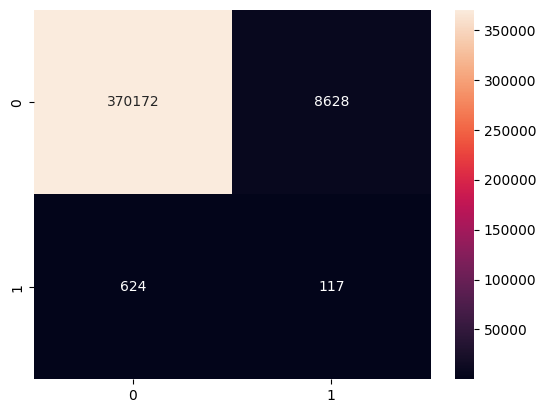

In [24]:
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_preds = model.predict(X_test)
evaluate_model(y_test, rcf_preds)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

/tmp/ipykernel_26201/2796411842.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [26]:
df = pd.read_pickle("all_df.pkl")
test_df_original = pd.read_pickle("all_df_test.pkl")

In [27]:
def plot_nan_freq(df):
    nan_counts = df.isnull().sum().sort_values(ascending=False)
    nan_perc = nan_counts / len(df) * 100
    print(nan_perc)
    # Define color palette
    colors = sns.color_palette("rocket", len(nan_counts))
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(nan_counts.index, nan_perc.values, color=colors)
    ax.set_xticks(range(len(nan_counts)))
    ax.set_xticklabels(nan_counts.index, rotation=90, ha='center', fontsize=10)
    ax.tick_params(axis='x', which='major', pad=15)
    ax.set_ylabel('Percentage of NaN values', fontweight = "bold")
    ax.set_xlabel('Data columns', fontweight = "bold")
    ax.set_title('Missing data Frequency per Column', fontweight = "bold")
    y_ticks = np.arange(0, 101, 10)
    ax.set_yticks(y_ticks)
    plt.grid(False)

    # Add text labels to highest and lowest non-zero bars
    non_zero_perc = nan_perc[nan_perc > 0]
    if len(non_zero_perc) > 0:
        max_idx = non_zero_perc.idxmax()
        min_idx = non_zero_perc.idxmin()
        ax.text(max_idx, non_zero_perc[max_idx]+1, f'{non_zero_perc[max_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')
        ax.text(min_idx, non_zero_perc[min_idx]+3, f'{non_zero_perc[min_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')

    plt.show()

Bilirubin_direct    99.810662
Fibrinogen          99.357921
TroponinI           99.031666
Bilirubin_total     98.528852
Alkalinephos        98.420491
AST                 98.403670
Lactate             97.321107
PTT                 97.092650
SaO2                96.499862
EtCO2               96.421753
Phosphate           96.028213
HCO3                95.852176
Chloride            95.490713
BaseExcess          94.513381
PaCO2               94.392242
Calcium             94.142921
Platelets           94.073419
Creatinine          93.923071
Magnesium           93.711304
WBC                 93.602813
BUN                 93.149290
pH                  92.990596
Hgb                 92.602401
FiO2                91.681010
Hct                 91.116257
Potassium           90.659996
Glucose             82.824912
Temp                66.077269
Unit1               39.010072
Unit2               39.010072
DBP                 31.189463
Resp                15.431408
SBP                 14.713047
O2Sat     

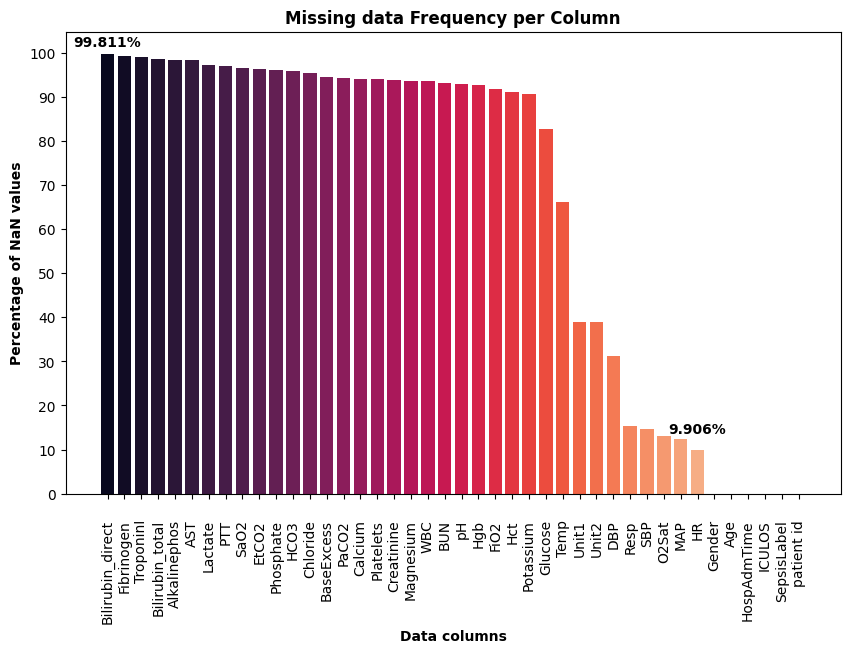

In [28]:
plot_nan_freq(df)

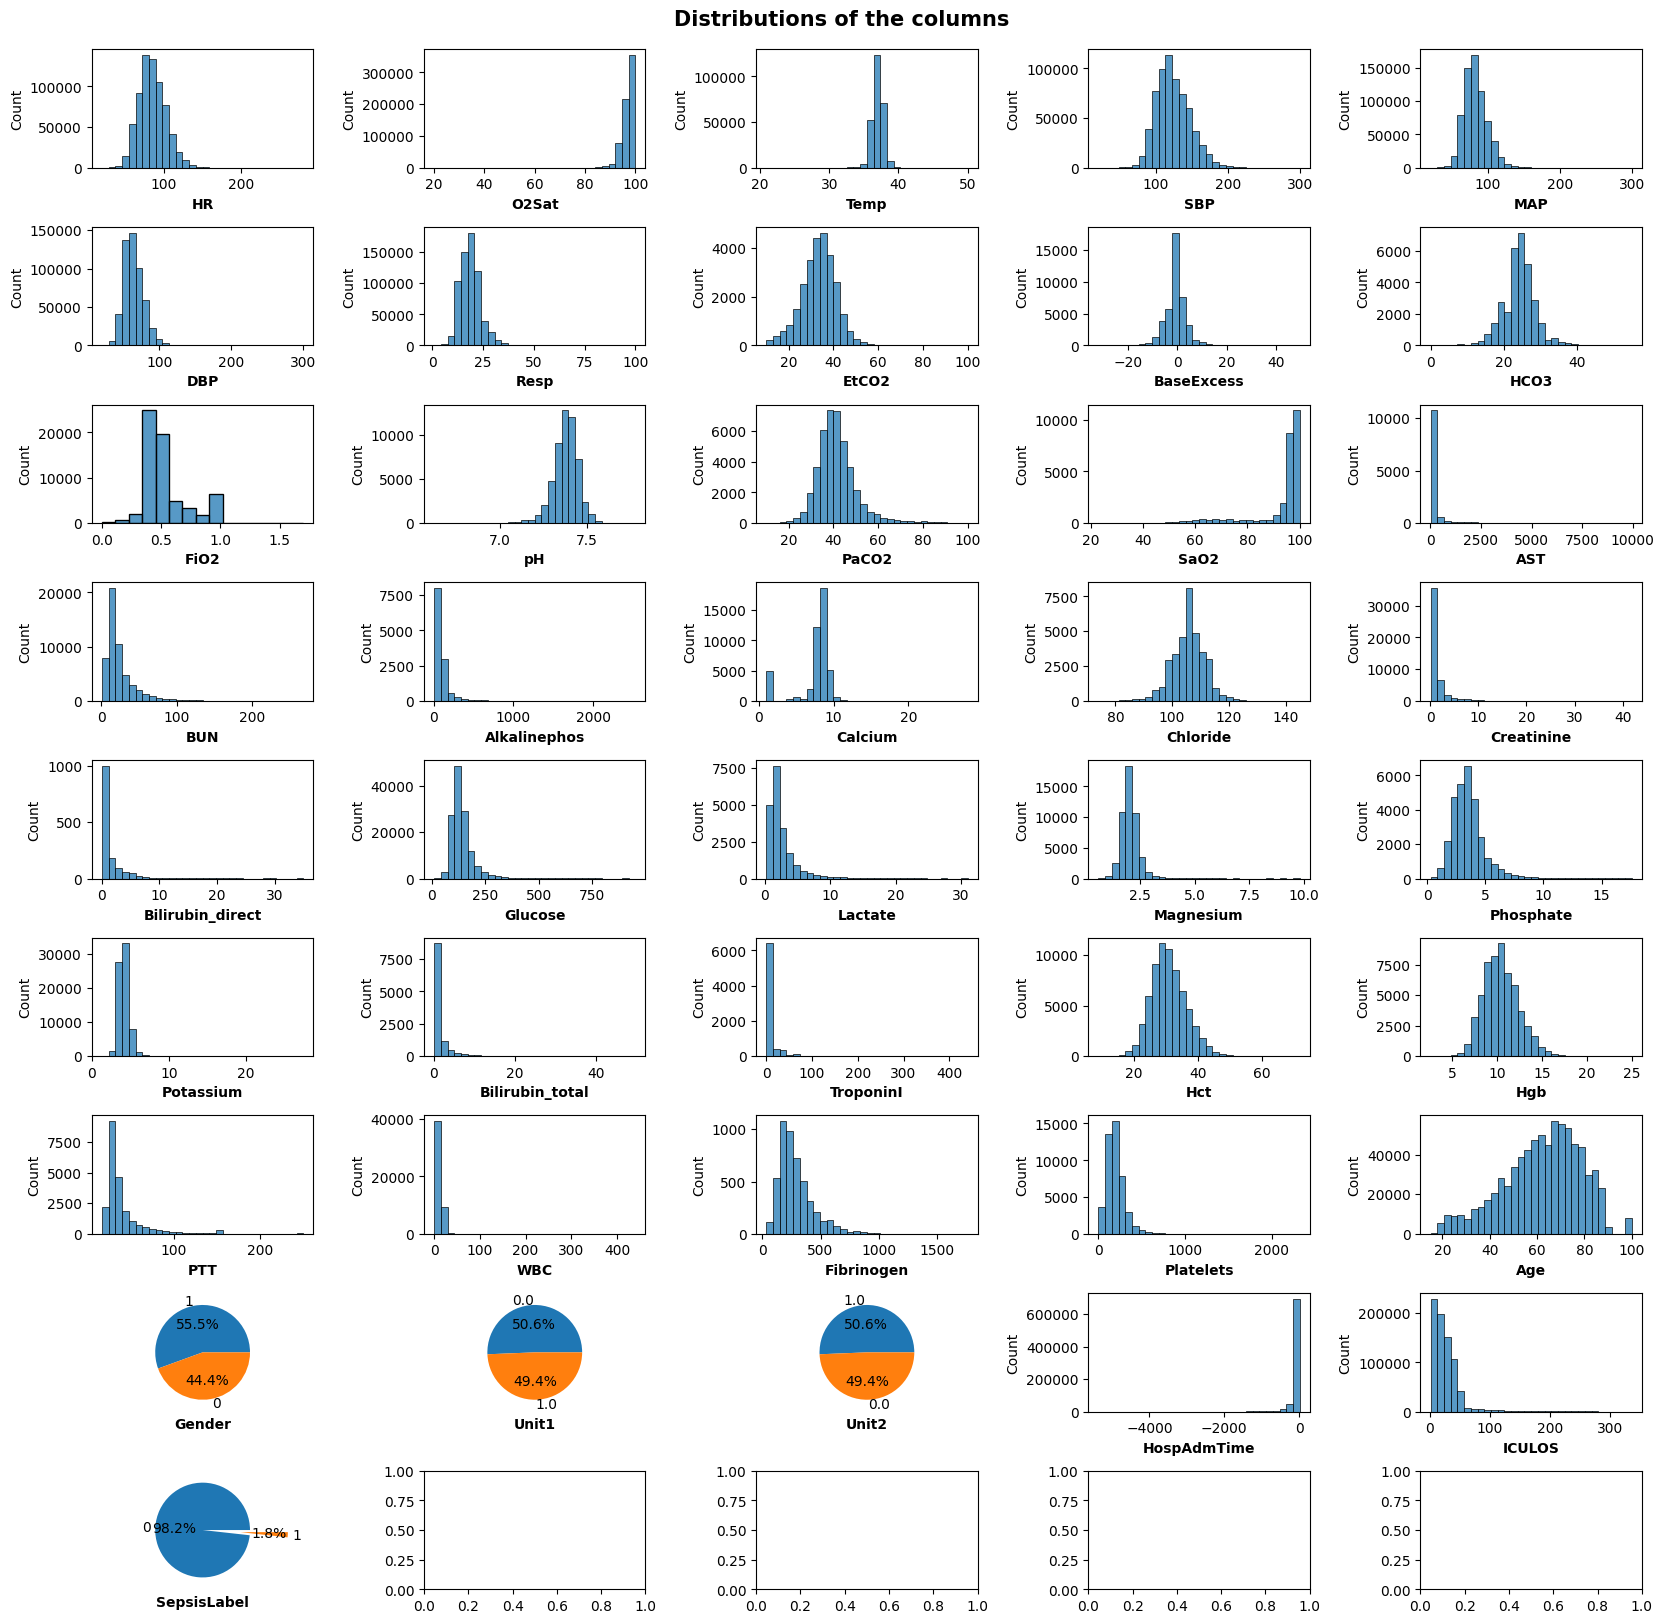

In [29]:
columns = df.columns.tolist()

fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Distributions of the columns", fontsize=15, fontweight="bold", y=0.9)

i = 0
for col in df.columns:
    if col != "patient id":
        if df[col].nunique() == 2:
            if col != 'SepsisLabel':
                counts = df.groupby('patient id')[col].mean().value_counts()
            else:
                counts = df[col].value_counts()
            if counts[1]/(counts[0]+counts[1]) > 0.95 or counts[1]/(counts[0]+counts[1]) < 0.05:
                axes[i//5, i%5].pie(counts, labels=counts.index, autopct='%1.1f%%', explode=(0, 0.8))
            else:
                axes[i//5, i%5].pie(counts, labels=counts.index, autopct='%1.1f%%')
        else:
            if col == "FiO2":
                curr_df = df[~df[col].isin([4000, -50, 7, 2])]
                sns.histplot(curr_df[col], ax=axes[i//5, i%5], bins=15)
            else:
                sns.histplot(df[col], ax=axes[i//5, i%5], bins=30)
                
        axes[i//5, i%5].set_xlabel(col, fontweight="bold")
        axes[i//5, i%5].grid(False)
        i += 1

plt.show()

In [30]:
def outliers_perc_of_col(target, df):
    df_not_null = df[target].dropna()
    Q1 = np.percentile(df_not_null, 25)
    Q3 = np.percentile(df_not_null, 75)
    IQR = Q3 - Q1
    ul = Q3 + 1.5 * IQR
    ll = Q1 - 1.5 * IQR
    outliers = df_not_null[(df_not_null > ul) | (df_not_null < ll)]
    outliers_per = round((len(outliers)/len(df_not_null))*100,2)
    return outliers_per

In [31]:
outlier_perc_dict = {}
for col in df.columns:
    outlier_perc_dict[col] = [outliers_perc_of_col(col, df)]
    
outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
outliers_perc_df.columns = ["Outliers %"]
outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
outliers_perc_df

,Outliers %
TroponinI,17.01
SaO2,15.69
AST,15.10
Calcium,14.21
HospAdmTime,13.91
Bilirubin_total,12.75
Creatinine,12.07
Bilirubin_direct,11.50
PTT,10.85
FiO2,10.53


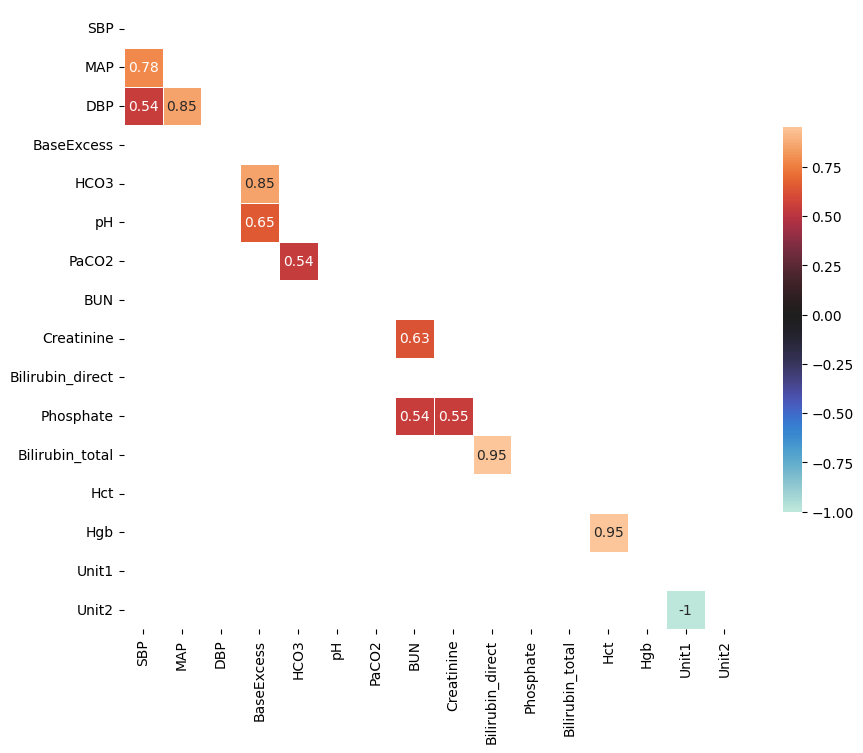

In [32]:
corr = df.corr()
corr = corr[corr.abs() > 0.5]
np.fill_diagonal(corr.values, np.NaN)
corr = corr.dropna(axis=0, how='all').dropna(axis=1, how='all') # Drop blank rows and columns
f, ax = plt.subplots(figsize=(10, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask = mask, center=0, square=True, linewidth=0.5, cbar_kws={"shrink":0.5})
plt.grid(False)
plt.show()

In [33]:
#Based on the above correlations, we will drop some columns
columns_to_drop = {'DBP', 'SBP','pH','HCO3', 'Hgb'}
df_dropped = df.drop(columns = columns_to_drop)
df_dropped

,HR,O2Sat,Temp,MAP,Resp,EtCO2,BaseExcess,FiO2,PaCO2,SaO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,75.91,0,0.0,1.0,-98.60,1,0,0
1,61.0,99.0,36.44,65.0,17.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,75.91,0,0.0,1.0,-98.60,2,0,0
2,64.0,98.0,NaN,64.0,27.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,75.91,0,0.0,1.0,-98.60,3,0,0
3,56.0,100.0,NaN,65.0,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,75.91,0,0.0,1.0,-98.60,4,0,0
4,66.0,99.0,NaN,67.0,23.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,75.91,0,0.0,1.0,-98.60,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766879,76.0,NaN,NaN,53.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,50,0,19999
766880,81.0,99.0,NaN,51.0,17.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,51,0,19999
766881,85.0,100.0,NaN,48.0,26.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,52,0,19999
766882,86.0,93.0,NaN,44.0,22.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,83.14,0,NaN,NaN,-0.03,53,0,19999


In [34]:
# Filling missing data using bfill and ffil
df_impute = df_dropped.groupby('patient id').apply(lambda x: x.bfill().ffill())
df_impute

,HR,O2Sat,Temp,MAP,Resp,EtCO2,BaseExcess,FiO2,PaCO2,SaO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient id
0,61.0,99.0,36.44,65.0,17.5,NaN,NaN,NaN,NaN,NaN,...,NaN,158.0,75.91,0,0.0,1.0,-98.60,1,0,0
1,61.0,99.0,36.44,65.0,17.5,NaN,NaN,NaN,NaN,NaN,...,NaN,158.0,75.91,0,0.0,1.0,-98.60,2,0,0
2,64.0,98.0,36.22,64.0,27.0,NaN,NaN,NaN,NaN,NaN,...,NaN,158.0,75.91,0,0.0,1.0,-98.60,3,0,0
3,56.0,100.0,36.22,65.0,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,158.0,75.91,0,0.0,1.0,-98.60,4,0,0
4,66.0,99.0,36.22,67.0,23.0,NaN,NaN,NaN,NaN,NaN,...,NaN,158.0,75.91,0,0.0,1.0,-98.60,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766879,76.0,99.0,36.33,53.0,17.0,NaN,19.0,0.25,100.0,89.0,...,NaN,338.0,83.14,0,NaN,NaN,-0.03,50,0,19999
766880,81.0,99.0,36.33,51.0,17.0,NaN,19.0,0.25,100.0,89.0,...,NaN,338.0,83.14,0,NaN,NaN,-0.03,51,0,19999
766881,85.0,100.0,36.33,48.0,26.0,NaN,19.0,0.25,100.0,89.0,...,NaN,338.0,83.14,0,NaN,NaN,-0.03,52,0,19999
766882,86.0,93.0,36.33,44.0,22.0,NaN,19.0,0.25,100.0,89.0,...,NaN,338.0,83.14,0,NaN,NaN,-0.03,53,0,19999


Bilirubin_direct    93.564346
EtCO2               90.227596
Fibrinogen          86.343958
TroponinI           81.742350
Lactate             63.622660
BaseExcess          63.557722
SaO2                63.035087
Alkalinephos        60.503023
Bilirubin_total     60.112090
AST                 59.974651
FiO2                50.420924
PaCO2               48.806599
PTT                 45.589163
Chloride            45.215443
Unit1               39.010072
Unit2               39.010072
Phosphate           25.034686
Calcium             10.057323
Magnesium            8.909170
WBC                  4.293479
Platelets            4.253446
Hct                  3.861471
Creatinine           3.316929
BUN                  3.259424
Potassium            3.068000
Glucose              2.689846
Temp                 0.451698
MAP                  0.157390
Resp                 0.150740
O2Sat                0.032469
HR                   0.009649
Gender               0.000000
Age                  0.000000
HospAdmTim

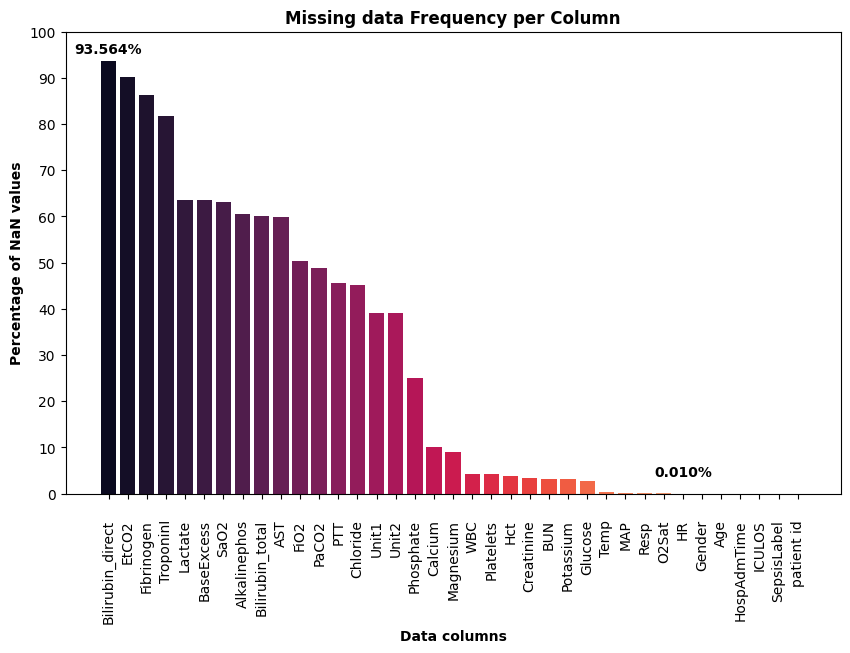

In [35]:
plot_nan_freq(df_impute)

In [36]:
# Dropping columns with 80% or higher null values
nan_counts = df_impute.isnull().sum().sort_values(ascending=False)
nan_perc = nan_counts / len(df) * 100
null_perc_df = pd.DataFrame(nan_perc, columns={"Percent"})
higher_than_80_cols = null_perc_df[null_perc_df['Percent'] > 80].index.tolist()
final_df = df_impute.drop(columns=higher_than_80_cols)
final_df

,HR,O2Sat,Temp,MAP,Resp,BaseExcess,FiO2,PaCO2,SaO2,AST,...,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient id
0,61.0,99.0,36.44,65.0,17.5,NaN,NaN,NaN,NaN,NaN,...,11.0,158.0,75.91,0,0.0,1.0,-98.60,1,0,0
1,61.0,99.0,36.44,65.0,17.5,NaN,NaN,NaN,NaN,NaN,...,11.0,158.0,75.91,0,0.0,1.0,-98.60,2,0,0
2,64.0,98.0,36.22,64.0,27.0,NaN,NaN,NaN,NaN,NaN,...,11.0,158.0,75.91,0,0.0,1.0,-98.60,3,0,0
3,56.0,100.0,36.22,65.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11.0,158.0,75.91,0,0.0,1.0,-98.60,4,0,0
4,66.0,99.0,36.22,67.0,23.0,NaN,NaN,NaN,NaN,NaN,...,11.0,158.0,75.91,0,0.0,1.0,-98.60,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766879,76.0,99.0,36.33,53.0,17.0,19.0,0.25,100.0,89.0,16.0,...,14.7,338.0,83.14,0,NaN,NaN,-0.03,50,0,19999
766880,81.0,99.0,36.33,51.0,17.0,19.0,0.25,100.0,89.0,16.0,...,14.7,338.0,83.14,0,NaN,NaN,-0.03,51,0,19999
766881,85.0,100.0,36.33,48.0,26.0,19.0,0.25,100.0,89.0,16.0,...,14.7,338.0,83.14,0,NaN,NaN,-0.03,52,0,19999
766882,86.0,93.0,36.33,44.0,22.0,19.0,0.25,100.0,89.0,16.0,...,14.7,338.0,83.14,0,NaN,NaN,-0.03,53,0,19999


In [37]:
def normal_QQ_plot(original_df, columns):
    df = original_df.copy()
    fig, axes = plt.subplots(nrows=26, ncols=3, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    i = 0
    for col in columns:
        print(col)
        sns.histplot(df[col], ax=axes[i, 0], bins=30)
        stats.probplot(df[col], dist="norm", plot=axes[i,1])
        if df[col].min() > -1:
            df[f"{col}_log"] = np.log(df[col]+1)
            stats.probplot(df[f"{col}_log"], dist="norm", plot = axes[i,2])
        plt.grid(False)
        axes[i,0].set_title(f"{col} Histogram")
        axes[i,1].set_title(f"{col} QQ plot")
        axes[i,2].set_title(f"{col} Log values QQ plot")
        i += 1
    plt.grid(False)
    plt.show()

In [38]:
# columns = final_df.columns
# columns_to_plot = columns.drop(['Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
#        'patient id'])
# normal_QQ_plot(final_df, columns_to_plot)

In [55]:
#UnderSampling
majority_class = final_df[final_df['SepsisLabel'] == 0]
minority_class = final_df[final_df['SepsisLabel'] == 1]
print("Original ratio: ")
print(len(majority_class))
print(len(minority_class))

majority_subset = majority_class.sample(n=2*len(minority_class))
balanced_df = pd.concat([majority_subset, minority_class])
majority_class = balanced_df[balanced_df['SepsisLabel'] == 0]
minority_class = balanced_df[balanced_df['SepsisLabel'] == 1]
print("\nBalanced Ratio:")
print(len(majority_class))
print(len(minority_class))

Original ratio: 
753402
13482

Balanced Ratio:
26964
13482


In [56]:
# Filling missing data with the Outlier-based mean-median filling
filled_df = balanced_df.copy()
columns = balanced_df.columns
for col in columns:
    median = filled_df[col].median()
    avg =filled_df[col].mean()
    mode = filled_df[col].mode()[0]
    outlier_perc = outliers_perc_df.loc[col,'Outliers %']
    if filled_df[col].nunique() == 2:
        filled_df[col] = filled_df[col].fillna(mode)
    else:
        if outlier_perc <= 5:
            filled_df[col] = filled_df[col].fillna(avg)
        elif outlier_perc > 5:
            filled_df[col] = filled_df[col].fillna(median)

filled_df

,HR,O2Sat,Temp,MAP,Resp,BaseExcess,FiO2,PaCO2,SaO2,AST,...,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient id
266660,100.0,97.0,36.20,67.00,15.0,0.0,0.5,46.0,93.0,22.0,...,5.6,238.0,39.00,1,1.0,0.0,-373.47,36,0,7014
429242,58.0,96.0,36.94,56.33,14.0,-2.0,0.5,47.0,97.0,35.0,...,28.9,259.0,70.26,0,1.0,0.0,-0.03,12,0,11296
668094,60.0,99.0,36.06,103.00,20.0,0.0,0.5,40.0,97.0,35.0,...,6.6,198.0,67.05,1,1.0,0.0,-0.80,2,0,17464
460231,86.0,95.0,38.80,73.00,16.0,0.0,0.4,33.0,98.0,35.0,...,21.0,156.0,85.02,0,0.0,1.0,2.98,17,0,12107
366814,102.0,100.0,37.90,64.00,20.0,0.0,0.5,40.0,97.0,19.0,...,7.5,156.0,72.00,1,1.0,0.0,-26.74,8,0,9640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766013,79.0,97.5,36.33,72.00,33.0,0.0,0.5,40.0,97.0,24.0,...,10.0,379.0,33.53,0,1.0,0.0,-0.71,10,1,19977
766014,87.5,98.5,36.33,72.00,27.5,0.0,0.5,40.0,97.0,24.0,...,10.0,379.0,33.53,0,1.0,0.0,-0.71,11,1,19977
766015,85.0,95.0,36.33,62.67,30.0,0.0,0.5,40.0,97.0,24.0,...,10.0,379.0,33.53,0,1.0,0.0,-0.71,12,1,19977
766016,82.0,96.0,36.33,57.00,30.0,0.0,0.5,40.0,97.0,24.0,...,10.0,379.0,33.53,0,1.0,0.0,-0.71,13,1,19977


In [41]:
def evaluate_model(y_true,y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred)
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred)
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred)
    print("F1 Score:", f1)
    auc = roc_auc_score(y_true, y_pred)
    print("AUC-ROC:", auc)
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error:", mae)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", rmse)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel("predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [42]:
def preprocess(df):
    #Based on the above correlations, we will drop some columns
    columns_to_drop = {'DBP', 'SBP','pH','HCO3', 'Hgb'}
    df_dropped = df.drop(columns = columns_to_drop)
    # Filling missing data using bfill and ffil
    df_impute = df_dropped.groupby('patient id').apply(lambda x: x.bfill().ffill())
    df_impute
    # Dropping columns with 80% or higher null values
    higher_than_80_cols = ['Bilirubin_direct', 'EtCO2', 'Fibrinogen', 'TroponinI']
    final_df = df_impute.drop(columns=higher_than_80_cols)
    final_df
    #Calculating outliers
    outlier_perc_dict = {}
    for col in final_df.columns:
        outlier_perc_dict[col] = [outliers_perc_of_col(col, final_df)]

    outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
    outliers_perc_df.columns = ["Outliers %"]
    outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
    outliers_perc_df
    # Filling missing data with the Outlier-based mean-median filling
    filled_df = final_df.copy()
    columns = final_df.columns
    for col in columns:
        median = filled_df[col].median()
        avg =filled_df[col].mean()
        mode = filled_df[col].mode()[0]
        outlier_perc = outliers_perc_df.loc[col,'Outliers %']
        if filled_df[col].nunique() == 2:
            filled_df[col] = filled_df[col].fillna(mode)
        else:
            if outlier_perc <= 5:
                filled_df[col] = filled_df[col].fillna(avg)
            elif outlier_perc > 5:
                filled_df[col] = filled_df[col].fillna(median)
    return filled_df

In [53]:
def transform_to_train_test(prev_train_df, test_df_original):
    X_train = prev_train_df.drop('SepsisLabel', axis=1)
    y_train = prev_train_df['SepsisLabel']

    test_df = preprocess(test_df_original)
    X_test = test_df.drop('SepsisLabel', axis=1)
    y_test = test_df['SepsisLabel']
    
    return X_train, y_train, X_test, y_test

Accuracy: 0.9763345725494742
Precision: 0.014492753623188406
Recall: 0.1659919028340081
F1 Score: 0.026657997399219764
AUC-ROC: 0.5719558247010589
Mean Absolute Error: 0.023665427450525765
Root Mean Squared Error: 0.1538357157831879


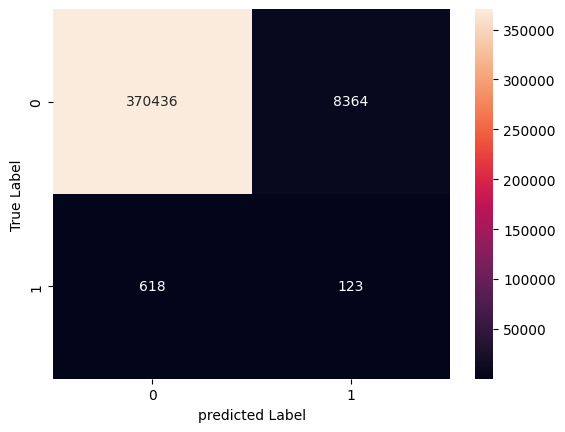

In [57]:
# Using only Under-sample and prediction per row
X_train, y_train, X_test, y_test = transform_to_train_test(filled_df, test_df_original)
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_preds = model.predict(X_test)
evaluate_model(y_test, rcf_preds)

Accuracy: 0.9347
Precision: 0.676
Recall: 0.22807017543859648
F1 Score: 0.3410696266397579
AUC-ROC: 0.609660965243869
Mean Absolute Error: 0.0653
Root Mean Squared Error: 0.25553864678361277


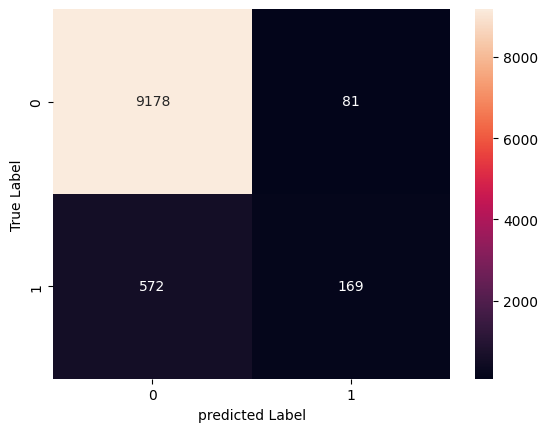

In [58]:
# If there is at least one prediction of 1 for a patient, it will be classified as 1
test_df['preds'] = rcf_preds
preds_list = pd.DataFrame(test_df.groupby('patient id')['preds'].apply(lambda x: (x==1).any()).astype(int))['preds'].to_list()
true_list = pd.DataFrame(test_df.groupby('patient id')['SepsisLabel'].apply(lambda x: (x==1).any()).astype(int))['SepsisLabel'].to_list()
evaluate_model(true_list, preds_list)

Accuracy: 0.9336
Precision: 0.6115942028985507
Recall: 0.28475033738191635
F1 Score: 0.3885819521178637
AUC-ROC: 0.635138966077285
Mean Absolute Error: 0.0664
Root Mean Squared Error: 0.25768197453450253


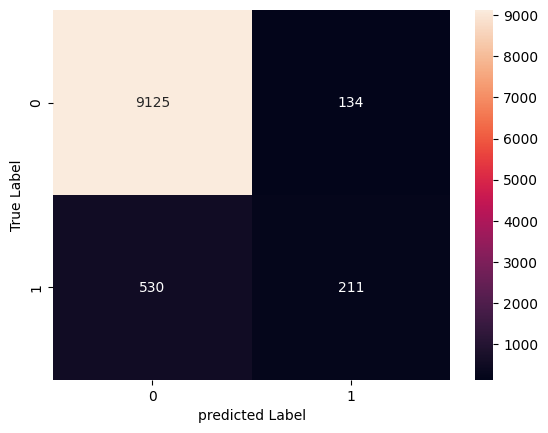

In [59]:
# Same as above, using min_sample_leaf
model = RandomForestClassifier(n_estimators=300, random_state=0, min_samples_leaf=3)
model.fit(X_train, y_train)
rcf_preds = model.predict(X_test)
test_df['preds'] = rcf_preds
preds_list = pd.DataFrame(test_df.groupby('patient id')['preds'].apply(lambda x: (x==1).any()).astype(int))['preds'].to_list()
true_list = pd.DataFrame(test_df.groupby('patient id')['SepsisLabel'].apply(lambda x: (x==1).any()).astype(int))['SepsisLabel'].to_list()
evaluate_model(true_list, preds_list)

In [48]:
def sample_data(df, output, SEED=33):
    X = df.drop([output], axis=1)
    y = df[output]
    col_names = pd.concat([X, y], axis=1).columns.tolist()

    over_sampler = SMOTE(random_state=SEED, sampling_strategy=0.1)
    under_sampler = RandomUnderSampler(random_state=SEED, sampling_strategy=0.5)

    pipeline = Pipeline(steps=[('over', over_sampler), ('under', under_sampler)])

    X_sampled, y_sampled = pipeline.fit_resample(X, y)
    y_sampled = y_sampled.to_numpy()
    sampled_array = np.concatenate([X_sampled, y_sampled.reshape(-1, 1)], axis=1)

    df_sampled = pd.DataFrame(sampled_array, columns=col_names)
    org_int_cols = df.dtypes.index[df.dtypes == 'int64'].tolist()
    org_float_cols = df.dtypes.index[df.dtypes == 'float64'].tolist()
    try:
        for col in col_names:
            if col in org_float_cols:
                df_sampled[col] = df_sampled[col].astype('float64')
            elif col in org_int_cols:
                df_sampled[col] = df_sampled[col].astype('int64')
    except:
        raise ValueError

    return df_sampled

In [60]:
# Filling missing data with the Outlier-based mean-median filling
filled_df = final_df.copy()
columns = final_df.columns
for col in columns:
    median = filled_df[col].median()
    avg =filled_df[col].mean()
    mode = filled_df[col].mode()[0]
    outlier_perc = outliers_perc_df.loc[col,'Outliers %']
    if filled_df[col].nunique() == 2:
        filled_df[col] = filled_df[col].fillna(mode)
    else:
        if outlier_perc <= 5:
            filled_df[col] = filled_df[col].fillna(avg)
        elif outlier_perc > 5:
            filled_df[col] = filled_df[col].fillna(median)
            
majority_class = filled_df[filled_df['SepsisLabel'] == 0]
minority_class = filled_df[filled_df['SepsisLabel'] == 1]
print("Original ratio: ")
print(len(majority_class))
print(len(minority_class))
balanced_df = sample_data(filled_df, 'SepsisLabel', SEED=33)
majority_class = balanced_df[balanced_df['SepsisLabel'] == 0]
minority_class = balanced_df[balanced_df['SepsisLabel'] == 1]
print("\nBalanced Ratio:")
print(len(majority_class))
print(len(minority_class))

Original ratio: 
753402
13482

Balanced Ratio:
150680
75340


Accuracy: 0.9289
Precision: 0.8409090909090909
Recall: 0.04993252361673414
F1 Score: 0.09426751592356687
AUC-ROC: 0.5245882512240706
Mean Absolute Error: 0.0711
Root Mean Squared Error: 0.26664583251946766


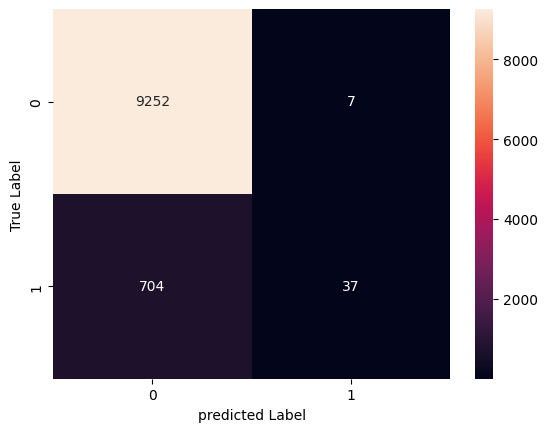

In [62]:
# Using Under-sampling and Over-sampling & min_sample_leaf.
X_train, y_train, X_test, y_test = transform_to_train_test(balanced_df, test_df_original)
model = RandomForestClassifier(n_estimators=300, random_state=0,  min_samples_leaf=3)
model.fit(X_train, y_train)
rcf_preds = model.predict(X_test)
test_df['preds'] = rcf_preds
preds_list = pd.DataFrame(test_df.groupby('patient id')['preds'].apply(lambda x: (x==1).any()).astype(int))['preds'].to_list()
true_list = pd.DataFrame(test_df.groupby('patient id')['SepsisLabel'].apply(lambda x: (x==1).any()).astype(int))['SepsisLabel'].to_list()
evaluate_model(true_list, preds_list)